## Importing the necessary libraries

In [1]:
import os
import re
import sys
import json
import time
import html
import textwrap
from typing import Optional, TypedDict, List, Dict

import requests
from bs4 import BeautifulSoup, NavigableString
from dotenv import load_dotenv

# LangChain / LangGraph
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.language_models import BaseChatModel
from langgraph.graph import StateGraph, START, END
from langchain_groq import ChatGroq

In [3]:
load_dotenv()
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

### Using Llama 4 from Groq API inference providers

In [4]:
llm = ChatGroq(model="meta-llama/llama-4-scout-17b-16e-instruct", temperature=0.6)
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000019CDE551A30>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000019CDE6951F0>, model_name='meta-llama/llama-4-scout-17b-16e-instruct', temperature=0.6, model_kwargs={}, groq_api_key=SecretStr('**********'))

In [ ]:
class ArticleState(TypedDict):
    url: str                                  # The original URL of the article to be analyzed
    article_text: str                         # The full extracted textual content of the article (cleaned HTML)
    article_title: str      
    core_claims: List[str]                    # List of 3–5 main factual claims extracted from the article
    language_tone: str                        ## Short description of the article's language and tone
    red_flags: List[str]                      # Potential bias indicators or quality issues in reporting
    counter_argument: str                     # Alternative summary of the article from an opposing viewpoint
    verification_questions: List[str]         # Specific questions a reader can ask to verify the claims
    report_md: str                            # The complete Markdown report generated from all analysis steps


# Creating the graph nodes

In [ ]:
# Node function to fetch the article content from the URL
def fetch_article(state: ArticleState):
    url = state["url"]
    try:
        response = requests.get(url)
        soup = BeautifulSoup(response.text, "html.parser")

        # Extract title
        title_tag = soup.find("title")
        state["article_title"] = title_tag.get_text(strip=True) if title_tag else "Untitled Article"

        # Remove scripts and styles
        for s in soup(["script", "style"]):
            s.extract()

        # Extract visible text
        paragraphs = [p.get_text(strip=True) for p in soup.find_all("p")]
        text = "\n".join(paragraphs)

        state["article_text"] = text
    except Exception as e:
        state["article_text"] = ""
        state["article_title"] = "Untitled Article"
        print(f"Error fetching article: {e}")
    return state


In [ ]:
# Node function to extract the main claims from the article
def extract_core_claims(state: ArticleState):
    prompt = f"""
    You are a critical fact-extraction assistant.

    ARTICLE:
    {state["article_text"]}

    TASK:
    Identify the 3-5 main factual claims made in the above article.
    Return them as a bullet list.
    """
    resp = llm.invoke(prompt)
    state["core_claims"] = resp.content.strip().split("\n")
    return state


In [ ]:
# Node function to view the arcticle in counter intuitive way
def simulate_counter_argument(state: ArticleState):
    prompt = f"""
    You are a critical thinking assistant.

    ARTICLE:
    {state["article_text"]}

    TASK:
    Briefly summarize the article from a hypothetical opposing viewpoint, highlighting 
    potential counter-arguments and alternative interpretations.

    Keep it concise (3-4 sentences).
    """
    resp = llm.invoke(prompt)
    state["counter_argument"] = resp.content.strip()
    return state


In [ ]:
# Node function to identidy lannguage tone
def analyze_language_tone(state: ArticleState):
    prompt = f"""
    You are a language tone analysis assistant.

    ARTICLE:
    {state["article_text"]}

    TASK:
    Classify the overall language and tone of the article in 1-2 sentences.
    Examples: 
    - Appears neutral and factual
    - Uses emotionally charged and persuasive language
    - Reads as a strong opinion piece
    """
    resp = llm.invoke(prompt)
    state["language_tone"] = resp.content.strip()
    return state


In [ ]:
# Node function to identify potential red flags in the article
def detect_red_flags(state: ArticleState):
    prompt = f"""
    You are a bias and red-flag detection assistant.

    ARTICLE:
    {state["article_text"]}

    TASK:
    Identify potential signs of bias or poor reporting.
    Examples include:
    - Loaded terminology
    - Over-reliance on anonymous sources
    - Lack of cited data
    - Failure to present opposing viewpoints

    Return as a bullet list.
    """
    resp = llm.invoke(prompt)
    state["red_flags"] = resp.content.strip().split("\n")
    return state


In [ ]:
#Node function to generate verification questions
def generate_verification_questions(state: ArticleState):
    prompt = f"""
    You are a fact verification assistant.

    ARTICLE:
    {state["article_text"]}

    TASK:
    Suggest 3-4 insightful, specific questions a reader should ask to independently verify the article's claims.
    Return as a bullet list.
    """
    resp = llm.invoke(prompt)
    state["verification_questions"] = resp.content.strip().split("\n")
    return state


In [ ]:
# Node function to compile the final Markdown report
def compile_markdown_report(state: ArticleState):
    md = f"# Critical Analysis Report: {state['article_title']}\n\n"

    md += "## 1. Core Claims\n"
    md += "\n".join(state["core_claims"]) + "\n\n"

    md += "## 2. Language & Tone Analysis\n"
    md += state["language_tone"] + "\n\n"

    md += "## 3. Potential Red Flags\n"
    md += "\n".join(state["red_flags"]) + "\n\n"

    md += "## 4. Verification Questions\n"
    md += "\n".join(state["verification_questions"]) + "\n"

    state["report_md"] = md
    return state


In [ ]:
# Creating the whole graph structure and printing it
workflow = StateGraph(ArticleState)

workflow.add_node("fetch_article", fetch_article)
workflow.add_node("extract_core_claims", extract_core_claims)
workflow.add_node("analyze_language_tone", analyze_language_tone)
workflow.add_node("detect_red_flags", detect_red_flags)
workflow.add_node("simulate_counter_argument", simulate_counter_argument)
workflow.add_node("generate_verification_questions", generate_verification_questions)
workflow.add_node("compile_markdown_report", compile_markdown_report)

workflow.set_entry_point("fetch_article")

workflow.add_edge("fetch_article", "extract_core_claims")
workflow.add_edge("extract_core_claims", "analyze_language_tone")
workflow.add_edge("analyze_language_tone", "detect_red_flags")
workflow.add_edge("detect_red_flags", "simulate_counter_argument")
workflow.add_edge("simulate_counter_argument", "generate_verification_questions")
workflow.add_edge("generate_verification_questions", "compile_markdown_report")
workflow.add_edge("compile_markdown_report", END)


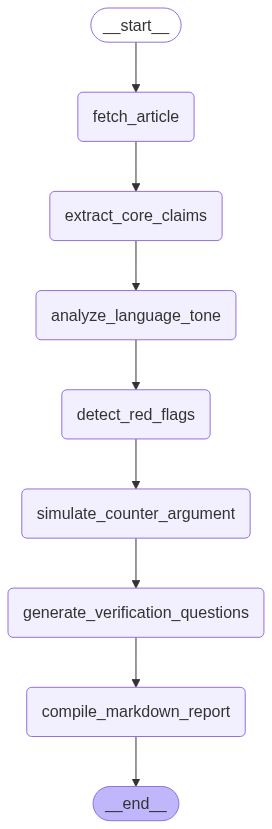

In [28]:
app = workflow.compile()
app

## Example 1: AI News Article Analysis

In [ ]:

app = workflow.compile()

# example
input_state = {
    "url": "https://info.deeplearning.ai/gpt-5s-rough-takeoff-ai-video-blockbusters-indias-homegrown-llms-synthetic-data-generation-1?ecid=ACsprvvOMBqo965Cqrim33UN9b1VIN329UHxNTaaNlXE6hi28qO1jPiCxEK_MwwiPh_2WbeO_vfP"  # Replace with your article URL
}

final_state = app.invoke(input_state)


print(final_state["report_md"])


# Critical Analysis Report: GPT-5’s Rough Takeoff, AI Video Blockbusters, India's Homegrown LLMs, Synthetic Data Generation

## 1. Core Claims
Here are the 3-5 main factual claims made in the article:

* **Universities are transforming to leverage AI**: The University of Exeter's Faculty of Environment, Science and Economy is a forward-looking example, with Computer Science sitting alongside Environmental Science and the Business School, creating opportunities for collaboration across fields.
* **OpenAI launched GPT-5, a new large language model**: GPT-5 is a family of systems, including GPT-5, GPT-5 Mini, GPT-5 Nano, and GPT-5 Pro, that integrate non-reasoning and variable-reasoning models with a router that switches between them automatically, but faced rollout issues and limitations.
* **India is developing native large language models**: India is funding startups and marshaling processing resources to build efficient models that can process many of the 22 officially recognized lang

## Example 2: Political News Article Analysis

In [ ]:

app = workflow.compile()

# Example URL
input_state = {
    "url": "https://www.bbc.com/news/articles/c776zrmy5jjo"  # Replace with your article URL
}

final_state = app.invoke(input_state)

# Display the Markdown report
print(final_state["report_md"])


# Critical Analysis Report: Alaska: US warns of additional tariffs on India if Trump-Putin peace talks fail

## 1. Core Claims
Here are the 3-5 main factual claims made in the article:

* The US Treasury Secretary Scott Bessent has warned that Washington could increase secondary tariffs on India, depending on the outcome of President Donald Trump's meeting with Russian counterpart Vladimir Putin.
* The US has already imposed a 25% penalty on India, in addition to 25% tariffs, for buying oil and weapons from Russia, which has strained India-US relations and disrupted ongoing trade talks.
* India's imports of Russian oil have increased significantly, making up 35-40% of its oil imports in 2024, up from 3% in 2021, and Delhi has defended its purchases by citing the need to buy cheap crude to protect its citizens from rising costs.
* A new 50% tariff rate on India is set to come into effect on August 27, which is expected to severely hamper India's exports-focused industries like textiles 